# Biofysikkprosjekt - Monte Carlo-simuleringer av polymerfolding

Vemund Aakre, Thorbjørn Djupvik og Oskar Feed Jakobsen

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.constants import Boltzmann
from pathlib import Path

---

I grove trekk er proteinar bygd opp av aminosyrer i lange kjedar.
Desse vil folde seg i det tredimensjonale rommet og ulike ledd i kjeden vil kunne vekselvirke seg imellom.
Generaliseringen av slike strukturar blir kalla polymerar. Polymerane består av repeterande einingar som blir kalla monomerar.
I dette prosjektet ser me på polymerfolding i to dimensjonar.
Me ynskjer å bruke Monte Carlo-simuleringar for å undersøke fysiske eigenskapar til slike strukturar.
Energi, romleg utstrekning og temperaturavhengigheiten til desse er størrelsar som skal undersøkast.

---

## The representation of a polymer
To represent a two dimensional polymer, one may try to create a two dimensional matrix to represent 2D space
and denote with for example 1 or 0 whether a monomer is located at a point in space or not. This will in general be 
unsuitable when scaling the problem, since the size of the matrix scales as $N^2$ with the size of the polymer. This also 
results in a higher computation time, because every computation done with the polymer requires iterating through the entire 
matrix. As most of the indices will be zero, this is a waste of space and time, and can be optimized.

A more efficient way of representing the polymer is just to store its monomer coordinates in a $N\times2$ matrix, reducing 
the matrix size to scale linearly with the size of the polymer. In our implementation the matrix has a size of $N\times2$, 
where each row contains the coordinate of a single monomer, $(x, y)$. The order of the rows is set to be the order
in which they appear in the polymer. For a polymer of size N, the structure would look like this:

$$
  \begin{bmatrix}
   x_1& y_1\\
   x_2& y_2\\
   \vdots&\vdots \\
   x_N& y_N\\
  \end{bmatrix}
$$

### A couple of conventions
Following the naming convention of the project description, we will name the first monomer 'monomer 1', and not by its index 
in the matrix. We will also define the head of a polymer with respect to a given monomer $i$, to be all monomers $j$
where $j<i$. The tail is defined identically for $j>i$.


## Polymers in action
To be able to work with polymers in the code, it is nice to have a function to automatically create a polymer of a given size 
without having to manually type it into the code.
The function `generate_flat_polymer` generates a flat polymer of a given length centered around the origin.

In [3]:
def generate_flat_polymer(
    polymer_length: int, mid_of_polymer: np.ndarray = np.zeros(2)
) -> np.ndarray:
    """Genererer en horisontal polymer med N monomerer

    Args:
        polymer_length (int): N antall monomerer
        mid_of_polymer (np.ndarray, optional): Midtpunktet til polymeren, Defaults to np.zeros(2).

    Returns:
        np.ndarray: den genererte polymeren
    """
    polymer_array = np.zeros((polymer_length, 2), dtype=np.int32)
    polymer_start = -int(polymer_length / 2) + mid_of_polymer[0]
    # + 1/2 for å håndtere partall
    polymer_end = int((polymer_length + 1) / 2) + mid_of_polymer[0]
    polymer_array[:, 1] = mid_of_polymer[1]
    polymer_array[:, 0] = np.arange(polymer_start, polymer_end, 1, dtype=np.int32)

    return polymer_array

While working with polymers, it is also beneficial to be able to visualize them. Both for debugging and analysis purposes. 
The function `illustrate_polymer` displays the polymer in a grid of size $N\times N$, with a color gradient to separate the 
monomers from each other.

In [4]:
def illustrate_polymer(
    polymer: np.ndarray,
    cmap: str = "binary",
    numbers: bool = False,
    title: str = "",
    save_to_file: bool = False,
    filename: str | Path = "",
) -> None:
    """
    Uses matplotlib.pyplot.pcolormesh to illustrate a polymer.

    Args:
        polymer: Nx2-dimensional array containing coordinates for the N monomers
        cmap: matplotlib colormap
        number: Defaults to False. If True the monomers will display their index
        title: Title
        save_to_file: Defaults to False
        filename: if save_to_file is True filename has to be specified.

    Returns:
        None
    """
    fig, ax = plt.subplots()

    # Make a NxN-grid
    N = len(polymer)
    x = y = np.arange(N + 1)
    Z = np.zeros((N, N))

    # Placing the polymer on the grid such that the middle monomer is in the center.
    middle_monomer = polymer[int(N / 2)]
    for i, monomer in enumerate(polymer):
        shifty = 1 if N % 2 == 0 and middle_monomer[1] < 0 else 0
        shiftx = 1 if N % 2 == 0 and middle_monomer[0] < 0 else 0
        x_coord = monomer[1] + int(N / 2) - middle_monomer[1] - shifty
        y_coord = monomer[0] + int(N / 2) - middle_monomer[0] - shiftx
        Z[x_coord, y_coord] = N + 2 - i
        if numbers:
            ax.text(y_coord + 0.5, x_coord + 0.5, i + 1, size="large", color="red")

    ax.pcolormesh(x, y, Z, shading="flat", cmap=cmap)
    ax.set(title=title, xticks=x, xticklabels=[], yticks=y, yticklabels=[])
    plt.tick_params(axis="both", left=False, right=False, bottom=False, top=False)
    ax.grid()

    if not save_to_file:
        plt.show()
    else:
        print(
            f"function illustrate_polymer() in {__file__}:\n\tsaving a plot to {filename}"
        )
        plt.savefig(filename)

La oss bruke `illustrate_polymer` til å sjå korleis ein flat polymer med lengde 10 ser ut. Nummereringa $1$-$10$ går frå hovudet til halen.

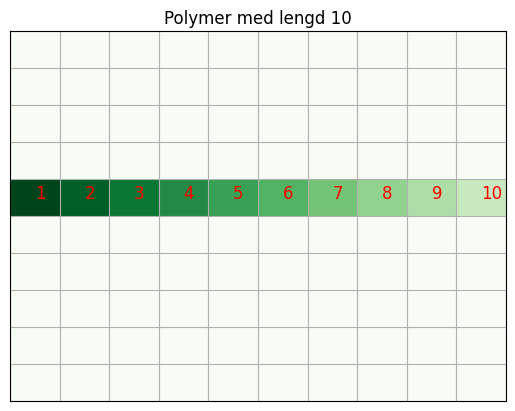

In [5]:
polymer = generate_flat_polymer(polymer_length=10)
illustrate_polymer(polymer, numbers=True, cmap="Greens", title="Polymer med lengd 10")

Eit polymer er *intakt* om det oppfyller dei tre krava i deloppgåve 1e):

**sitere?**
1. Det har $N$ monomerer.
2. Hver monomer representeres av et unikt heltall $m \in [1, N]$. Det vil si at ingen monomerer representeres av det samme tallet som en annen monomer.
3. En monomer representert av tallet $m$ skal være nærmeste nabo med monomerene
representert av tallene $m−1$ og $m+1$. Endemonomerene $m = 1$ og $m = N$ trenger kun å være nærmeste nabo med henholdsvis $m = 2$ og $m = N − 1$.




In [6]:
def check_if_intact(polymer: np.ndarray, polymer_length: int) -> bool:
    """Sjekker om en polymer er intakt

    Args:
        polymer (np.ndarray): polymeren som sjekkes
        polymer_length (int): lengden til polymeren

    Returns:
        bool: True hvis polymeren er intakt
    """
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False  # Sjekker både at den har N monomerer og at de alle har en unik heltallsrepresentasjon

    for i in range(1, polymer_length):
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2  ## Trenger ikke kvadratrot fordi alt annet enn 1 som verdi er ikke intakt(også raskere)
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2  ## Trenger ikke kvadratrot fordi alt annet enn 1 som verdi er ikke intakt(også raskere)
        if distance != 1:
            return False
    return True

To rotate a polymer around a given monomer, we only need to look at the relative position between the rotation center and the 
monomers which are to be rotated. Let's denote the coordinates of the rotation center as $(x_s, y_s)$, and of an arbitrary 
monomer as $(x_0, y_0)$. Then the relative position of the monomer with respect to the rotation center is given by
$$
    (x_{0, rel}, y_{0, rel}) = (x_0-x_s, y_0-y_s)
$$
. When the monomer is rotated, the new relative coordinates in terms of the old ones is
$$
    (x_{1, rel}, y_{1, rel}) = k \cdot (- y_{0, rel}, x_{0, rel})
$$
, where $k=1$ if the rotation is in the positive direction, and $k=-1$ if it is in the negative direction.
The new coordinates of the monomer then becomes
$$
    (x_{rot}, y_{rot}) = (x_s, y_s) + k \cdot (-y_{rel}, x_{rel}) = (x_s, y_s) + k \cdot (-(y_0 - y_s), x_0 - x_s)
$$
. When implementing this, one can make a small optimization by always rotating the shortest end of the polymer with respect 
to the rotation center. This reduces the number of computations and ensures that the center of the polymer does not move too 
much when rotating. In the case that the head and tail are equally long, it does not matter which one gets rotated. In our implementation we have defined it to just rotate the tail.


In [7]:
@njit
def rotate_polymer(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Rotates a polymer in the given direction around a monomer

    Args:
        polymer: A 2D numpy array with monomer coordinates

        rotation_center: Which monomer to rotate around
        `Note: It is not the index, but the monomer_number. [1, N]`

        positive_direction: Rotate in the positive direction if True, or negative direction if False

    Returns:
        a rotated copy of the polymer
    """
    # Make a slicing array to rotate the correct end of the polymer
    rotation_slice = np.full(len(polymer), False)

    # Choose to rotate the shortest tail of the polymer
    if rotation_center >= len(polymer) / 2:
        rotation_slice[rotation_center:] = True
    else:
        rotation_slice[:rotation_center] = True

    if positive_direction:
        direction = 1
    else:
        direction = -1

    # The coordinates in space of the rotation center
    rotation_position = polymer[rotation_center - 1]

    # Where _rel means the position relative to the rotation center
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_slice] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Changes the sign of the x-values

    # Makes a copy of the polymer
    # TODO: om lettere å mutere for så å mutere tilbake igjen
    # new_polymer = polymer[:]
    new_polymer = polymer.copy()

    new_polymer[rotation_slice] = rotation_position + new_pos_rel
    return new_polymer

Implenetasjon av algoritme 1 (**sitere?**):

In [10]:
def alg1(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Implementation of algorithm 1.
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for i in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            counter += 1
            pol = twisted_pol

    return pol, counter

La oss køyre `alg1` og visualisere resultatet. Først med $N = 15$ og $N_s = 4$. Deretter $N = 15$ og $N_s = 1000$. 

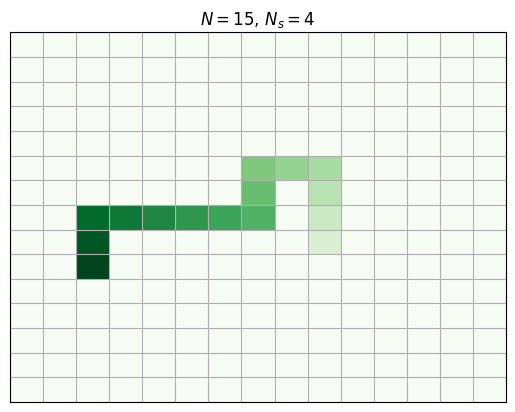

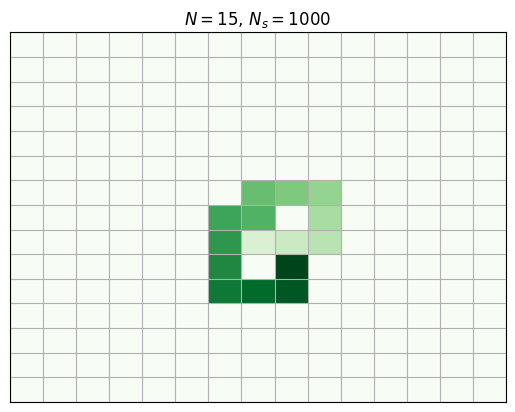

In [11]:
polymer_1, _ = alg1(N = 15, Ns = 4)
polymer_2, _ = alg1(N = 15, Ns = 1000)

illustrate_polymer(polymer_1, cmap="Greens", title="$N = 15$, $N_s = 4$")
illustrate_polymer(polymer_2, cmap="Greens", title="$N = 15$, $N_s = 1000$")

Det er nå eit godt tidspunkt å vurdera hastigheita til funksjonane som er implementert.

**insert episk innhold her**

La oss sjekke tidsbruken:

**%timeit eller egendefinerte benchmarks?**

**Korleis skalerar implementasjonen med $N$?**

In [18]:
%timeit alg1(N = 35, Ns = 1000)

229 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Energien til polymeren er definert slik:

$$
    E = \frac{1}{2} \sum_{m, n} V_{mn} b_{mn}
$$

**sjå prosjektbeskrivelse for forklaring. Kor mykje treng vi å inkludere her for at teksten skal ha god samanheng og flyt?**

Her er $N\times N$-matrisen $V$ ein konstant (som kan definerast på forhand) medan størrelsen $b_{mn}$ må reknast ut for kvar iterasjon:

\begin{equation}
 b_{mn} =
  \begin{cases}
  1 & m \text{ og } n \text{ nærmaste naboar} \\
  0 & \text{ellers} 
  \end{cases}
\end{equation}

For å rekne ut energien til eit monomer treng ein å vite kven av monomerane som er nærmaste naboar.

Me har to implementasjonar som har ulike styrkar og svakheiter:

- `calculate_energy`:
    - neg: brukar `for`-løkker. pos: utnyttar symmetrien til $V$ og $b$.
- `calculate_energy_2`
    - neg: brukar meir minne. pos: brukar utelukkande `numpy` og er dermed ein smule raskare
 
**visa til benchmarks og testing av hastigheit og minnebruk?** 

In [13]:
# Funksjonen kan, (og bør?), JIT-kompileres av numba
@njit()
def calculate_energy(polymer: np.ndarray, V: np.ndarray) -> np.float32:
    """Regner ut energien til et gitt polymer.

    Args:
        polymer: et numpy-array med monomer-koordinatene til et gyldig polymer

        V: matrise med styrken på vekselvirkninger mellom monomerene.
        V[i, j] = V[j, i] = styrken mellom monomer nummer (i+1) og (j+1)

    Returns:
        Energien til hele polymeret
    """
    N = len(polymer)
    # En matrise som angir om monomer (i+1) og (j+1) er naboer. b_matrix[i, j] = 1 dersom de er naboer.
    b_matrix = np.zeros((N, N))
    for i in range(0, N):
        # Trenger kun å se på monomer-sammensetninger som ikke har blitt sjekket enda.
        # Nabomonomeren er alltid en nabo uten vekselvirkning, så trenger ikke sjekke den.
        for j in range(i + 2, N):
            # Kun nærmeste-nabo koordinater gir en euklidsk avstand på nøyaktig 1.
            if np.sum((polymer[i] - polymer[j]) ** 2) == 1:
                # Trenger bare fylle den nedre trekanten av matrisen,
                # siden den ellers ville vært symmetrisk. (Merk j>i)
                b_matrix[j, i] = 1
    # Trenger ikke dele på 2 siden vi bare fyller ut den nedre trekanten av b_matrix;
    # vi dobbelteller ikke.
    return np.sum(V * b_matrix)

In [14]:
@njit
def calculate_energy_2(polymer: np.ndarray, V: np.ndarray) -> float:
    """idk... think it works. maybe. see Oskar's notebook for details lol."""
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2*N,N)
    b = np.where(np.abs(L[::2] - L[::2].transpose()) + np.abs(L[1::2] - L[1::2].transpose()) == 1, 1, 0)
    return 0.5*(np.sum(V*b))

---

## Oppgåve 2

**nødvendig med veldig utførleg forklaring her?**

In [15]:
def metropolis(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray]:
    """Kjører metropolis-algoritmen som beskrevet i oppgaveheftet

    Args:
        pol: polymer starttilstand
        N_s: Antall forsøk på rotasjon
        V: Vekselvirkningene mellom to gitte monomerer
        T: temperaturen i kelvin

    Returns:
        (Siste polymer , array med alle energiene som ble simulert)
    """
    E_array = np.zeros(N_s)
    N = len(pol)
    E = polymer.calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = polymer.rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if polymer.check_if_intact_2(twisted_pol, N):
            i += 1
            E_new = polymer.calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new
            # TODO: Bruke en annen distribusjon enn uniform?
            # TODO: Boltzmann-konstanten er liten. Sjekk at python håndterer det.
            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            E_array[i] = E

    return pol, E_array

La oss køyre to simuleringar av `metropolis`.

La $N \in \{20, 21, \dots, 35\}$, $N_s = 5000$ og 

**dette va schtøgt**
$$V =
  \begin{bmatrix}
   0& 0 & & &  &  −4.0&  \cdot& 10^{−21} &\text{J}\\
   0& 0 & 0 & &  &  &  &  & \\
   & 0 & 0 & 0 &  &  &  &  & \\
   &  & 0 & 0 &  &  &  &  & \\
   &  &  &  &  \ddots&  & &  & \\
   &  &  &  &  &  0&  0&  & \\
   &  &  &  &  &  0&  0&  0& \\
   −4.0&  \cdot& 10^{−21} &\text{J}  &  &  &  0&  0& 0\\
   &  &  &  &  &  &  &  0& 0\\
  \end{bmatrix}$$

Første simulering: $ 50 \text{K} < T_\text{lav} < 100 \text{K}$

Andre simulering: $ 293 \text{K} < T_\text{hoy} < 373 \text{K}$

Plott: $E$ som funksjon av Monte Carlo-steg $t$.


**svare på spørsmål:**

Sammenlign grafene og forklar det dere ser.

Hvilken av simuleringene oppnår den laveste energien i løpet av simuleringen? Forklar
hvorfor.

Hint: Her kan det være relevant å knytte drøftingen deres til konseptet av lokale energiminima.

In [16]:
# run the simulation

Illustasjon av sluttposisjonane frå oppgåva over:

In [17]:
# run illustration

Kommenter resultatet i lys av diskusjonen deres i 2b).

Lag så ein eigen $V$.

Basert på valget deres, hvordan forventer dere at en polymer med deres V folder seg? Kjør en
passende simulering der dere tester om polymeren folder seg på måten dere forventer.
Illustrer sluttposisjonen til polymeren og drøft resultatet.

Tips:
Hvis dere sliter med å komme på en interessant problemstilling kan dere for
eksempel vurdere å skalere enkelte av matriseelementene med en faktor 100. Hvordan vil dette påvirke strukturen til polymeren?

**2 e), f), g) og h)**

TODO